# Citation network topic modeling
In this notebook, we'll implement topic modeling on the various categories in the desiccation tolerance citation network

In [2]:
import jsonlines
import networkx as nx
import sys
sys.path.append('../desiccation_network/conference_recommendation')
sys.path.append('../data/')
from openai_key import API_KEY
import utils
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired, PartOfSpeech, OpenAI
import openai
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from transformers.pipelines import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import umap.plot
import sklearn

2024-01-31 17:37:13.968871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-31 17:37:16.517534: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.re

## Read in data
For now, doing this for main result network only (ignoring unclassified other references).

In [3]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_FILTERED_MAIN_ONLY_with_ref_abstracts_05Jan2023.jsonl') as reader:
    data = []
    for obj in reader:
        data.append(obj)

In [4]:
class_graph = nx.read_graphml('../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023_MANUALLY_VERIFIED.graphml')

Map classifications from the graph to the dataset with abstracts:

In [5]:
data_with_class = utils.map_classes_to_jsonl(class_graph, data, False, 'UID')

In [6]:
abstracts_and_classes = {'UID': [], 'abstract': [], 'study_system': [], 'year': []}
for paper in data_with_class:
    abstracts_and_classes['UID'].append(paper['UID'])
    abstracts_and_classes['abstract'].append(paper['abstract'])
    abstracts_and_classes['study_system'].append(paper['study_system'])
    abstracts_and_classes['year'].append(int(paper['year']))
abstracts = pd.DataFrame.from_dict(abstracts_and_classes, orient='columns').set_index('UID')
print(f'There are {len(abstracts)} abstracts in the dataset.')
abstracts.head()

There are 5564 abstracts in the dataset.


,abstract,study_system,year
UID,,,
WOS:A1990ET59600010,Four sorghum (Sorghum bicolor L. Moench) lines...,Plant,1990
WOS:000244317000009,Cynanchum komarovii is well adapted to hot and...,Plant,2007
WOS:000249421700004,Synergies between global change and biological...,Animal,2007
WOS:000251161900001,"Desiccation tolerance (DT), or the capacity to...",Plant,2007
WOS:000244031100003,Bean seed storage ability is of major interest...,Plant,2007


## Initialize embedding model
We can use [literally any embedding model we want](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers). We're going to use SciBERT as our first choice.

In [7]:
sentence_model = SentenceTransformer('allenai/scibert_scivocab_cased')

No sentence-transformers model found with name /mnt/home/lotrecks/.cache/torch/sentence_transformers/allenai_scibert_scivocab_cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /mnt/home/lotrecks/.cache/torch/sentence_transformers/allenai_scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be 

## Choose dimensionality reduction model
There are many [dimensionality reduction models](https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html) to choose from. We're going to start with the default UMAP and its default parameters, but we need to set a random seed so that we can reliably reproduce our results.

In [8]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

## Choose clustering model
There are many [clustering models](https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html) to choose from. We started with the default HDBSCAN and its default parameters, so no action is required here.

## Choose vectorizer
The [vectorizer](https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html) can be passed either before or after training. Passing before allows you to reduce the overall memory needed, while passing after allows you to fine tune the topics. Initially, we passed it after training, but some of the topic representation modelswe tested were negatively impacted by doing this; so we also define it here.

In [9]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)

## Choose representation model
We can improve our topic representations with different topic representation methods. We tried a few and looked at the largest topics and heuristically chose the best one, which was using ChatGPT.

In [14]:
client = openai.OpenAI(api_key=API_KEY)
representation_model = OpenAI(client, "gpt-3.5-turbo", chat=True)

## Train overall topic model
Now that we've set up our basic inputs, we can train our topic models. We're going to do several groups of topic models, but we'll start with the entire dataset together.

In [44]:
docs = abstracts.abstract.values.tolist()

In [45]:
topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, representation_model=representation_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)

In [46]:
topic_model.get_topic_info()[:10]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2522,-1_Desiccation tolerance in plants and its mol...,[Desiccation tolerance in plants and its molec...,[The growth and persistence of rhizobia and br...
1,0,476,0_Seed germination and storage behavior in rel...,[Seed germination and storage behavior in rela...,[Obtaining commercially useful coffee seedling...
2,1,358,1_Molecular Mechanisms of Plant Desiccation To...,[Molecular Mechanisms of Plant Desiccation Tol...,[Plants are often subjected to an array of div...
3,2,201,2_Somatic embryogenesis and cryopreservation f...,[Somatic embryogenesis and cryopreservation fo...,[Somatic embryogenesis (SE) represents a usefu...
4,3,144,3_Resurrection plants and their mechanisms of ...,[Resurrection plants and their mechanisms of d...,"[The resurrection plant, Haberlea rhodopensis ..."
5,4,118,4_Tardigrade radiation tolerance and survival ...,[Tardigrade radiation tolerance and survival i...,"[So far, most studies on tardigrade resistance..."
6,5,116,5_Desiccation tolerance and survival of bacter...,[Desiccation tolerance and survival of bacteri...,[Aims: The study aimed to compare survival of ...
7,6,108,6_Drought tolerance and grain yield in wheat a...,[Drought tolerance and grain yield in wheat an...,[Abscisic acid (ABA) plays a central role in t...
8,7,93,7_Thermal limits and habitat selection of inte...,[Thermal limits and habitat selection of inter...,[Rocky intertidal zones are some of the most t...
9,8,84,8_Plant gene expression in response to desicca...,[Plant gene expression in response to desiccat...,[Tortula ruralis is an important experimental ...


In [47]:
topic_model.get_topic_info().shape

(53, 5)

In [48]:
topic_model.visualize_topics()

## Fine-tune topic representations
There are lots of stopwords in our final topic representations when we use non-LLM methods. The commented-out code below is for performing a fine-tuning to remove stopwords for models that need it.

In [27]:
# vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [28]:
# topic_model.get_topic_info()[:10]

In [29]:
# topic_model.visualize_topics()

Much better! And the topic groups, while clearly redundant as they overlap in the embedding space, are still reasonably well separated in meta-groups. We can play around with more hyperparameters to try and reduce the number of outliers.

## Reducing outliers
There are ~3,000 outliers, which we can assign to clusters using the reduce outliers functionality of BERTopic.

In [49]:
new_topics = topic_model.reduce_outliers(docs, topics)

In [50]:
topic_model.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model)

2024-01-31 18:21:22,790 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [51]:
topic_model.get_topic_info()[:10]

,Topic,Count,Name,Representation,Representative_Docs
0,0,589,0_seeds_seed_germination_at,"[seeds, seed, germination, at, of, and, the, d...",[Obtaining commercially useful coffee seedling...
1,1,491,1_of_and_are_to,"[of, and, are, to, the, is, plants, in, as, me...",[Plants are often subjected to an array of div...
2,2,227,2_embryos_somatic_medium_sucrose,"[embryos, somatic, medium, sucrose, aba, of, w...",[Somatic embryogenesis (SE) represents a usefu...
3,3,272,3_the_of_in_desiccation,"[the, of, in, desiccation, rehydration, and, d...","[The resurrection plant, Haberlea rhodopensis ..."
4,4,221,4_the_to_of_radiation,"[the, to, of, radiation, and, in, tardigrades,...","[So far, most studies on tardigrade resistance..."
5,5,161,5_strains_to_the_of,"[strains, to, the, of, in, biofilm, and, salmo...",[Aims: The study aimed to compare survival of ...
6,6,156,6_drought_water_and_leaf,"[drought, water, and, leaf, stress, grain, yie...",[Abscisic acid (ABA) plays a central role in t...
7,7,202,7_species_to_and_the,"[species, to, and, the, of, in, that, water, i...",[Rocky intertidal zones are some of the most t...
8,8,170,8_protein_the_gene_of,"[protein, the, gene, of, aba, in, expression, ...",[Tortula ruralis is an important experimental ...
9,9,113,9_lea_proteins_protein_group,"[lea, proteins, protein, group, the, of, in, t...",[LEA (late embryogenesis abundant) proteins in...


## Map classifications to topics
We want to see what proportion of each topic is made up of each class, to see if there are some that are more dominated by one group or another. We would expect to see the same proportions as the overall graph if there were no difference in topics in each discipline, so major departures from those splits are what we're looking for.

In [21]:
topic_system_map = topic_model.get_document_info(docs)
topic_system_map['UID'] = abstracts.index
topic_system_map['study_system'] = abstracts['study_system'].values.tolist()
topic_system_map.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document,UID,study_system
0,Four sorghum (Sorghum bicolor L. Moench) lines...,6,6_drought_water_root_yield,"[drought, water, root, yield, leaf, stress, cu...",[Drought and heat stress are two major constra...,drought - water - root - yield - leaf - stress...,0.000000,False,WOS:A1990ET59600010,Plant
1,Cynanchum komarovii is well adapted to hot and...,2,2_embryos_somatic_somatic embryos_medium,"[embryos, somatic, somatic embryos, medium, ab...",[The limit of permeability of white spruce (Pi...,embryos - somatic - somatic embryos - medium -...,0.000000,False,WOS:000244317000009,Plant
2,Synergies between global change and biological...,7,7_species_intertidal_eggs_snails,"[species, intertidal, eggs, snails, habitat, w...",[P>Small-scale distributions of rocky intertid...,species - intertidal - eggs - snails - habitat...,0.000000,False,WOS:000249421700004,Animal
3,"Desiccation tolerance (DT), or the capacity to...",10,10_genes_proteins_dehydration_expression,"[genes, proteins, dehydration, expression, pro...",[Background: The plant hormone abscisic acid (...,genes - proteins - dehydration - expression - ...,0.000000,False,WOS:000251161900001,Plant
4,Bean seed storage ability is of major interest...,0,0_seeds_seed_germination_storage,"[seeds, seed, germination, storage, content, d...",[The effect of moisture content on the low tem...,seeds - seed - germination - storage - content...,0.948593,False,WOS:000244031100003,Plant


In [22]:
topic_system_map.study_system.value_counts().to_dict()

{'Plant': 3627, 'Animal': 1176, 'Microbe': 620, 'Fungi': 141}

In [23]:
topic_counts = topic_system_map['Topic'].value_counts().to_dict()

In [24]:
unique_topics = topic_system_map.drop_duplicates(subset=['Topic'])
unique_topics['joined_rep'] = unique_topics['Representation'].str.join(' | ')
topic_reps = unique_topics.set_index('Topic')['joined_rep'].to_dict()

In [48]:
topic_reps[48]

'trehalose | phosphate | trehalose phosphate | glucose | disaccharide | synthesis | synthase | trehalose accumulation | genes | accumulation'

In [47]:
topic_reps[4]

'radiation | tardigrades | anhydrobiotic | anhydrobiosis | sp | uv | strains | irradiation | survival | animals'

## Visualize class distribution in topic clusters

In [25]:
classes = list(topic_system_map['study_system'].unique())
classes

['Plant', 'Animal', 'Microbe', 'Fungi']

In [26]:
bars = defaultdict(list)
topic_order = []
for i in topic_system_map['Topic'].unique():
    bars['topic'].append(i)
    topic_df = topic_system_map[topic_system_map['Topic'] == i]
    group_counts = topic_df.study_system.value_counts()
    total_count = len(topic_df)
    group_props = {k: v/total_count for k, v in group_counts.items()}
    for k, v in group_props.items():
        bars[k].append(v)
    if len(group_props.keys()) != 5:
        for system in classes:
            if system not in group_props.keys():
                bars[system].append(0.0)
bars_df = pd.DataFrame.from_dict(bars)
bars_df = bars_df.sort_values('Plant', ascending=False)
bars_df = bars_df.set_index('topic').T
bars_df.head()

topic,27,33,40,37,0,36,42,14,32,25,...,21,34,22,4,29,39,35,5,15,16
Plant,1.0,1.0,1.0,1.0,0.978448,0.974359,0.947368,0.932886,0.931818,0.921739,...,0.179487,0.15493,0.138462,0.133663,0.12500,0.095238,0.081081,0.065574,0.030612,0.024390
Microbe,0.0,0.0,0.0,0.0,0.010057,0.000000,0.052632,0.040268,0.022727,0.000000,...,0.371795,0.00000,0.046154,0.405941,0.40625,0.000000,0.000000,0.885246,0.102041,0.012195
Animal,0.0,0.0,0.0,0.0,0.008621,0.025641,0.000000,0.020134,0.022727,0.069565,...,0.038462,0.84507,0.800000,0.445545,0.12500,0.857143,0.000000,0.021858,0.857143,0.963415
Fungi,0.0,0.0,0.0,0.0,0.002874,0.000000,0.000000,0.006711,0.022727,0.008696,...,0.410256,0.00000,0.015385,0.014851,0.34375,0.047619,0.918919,0.027322,0.010204,0.000000


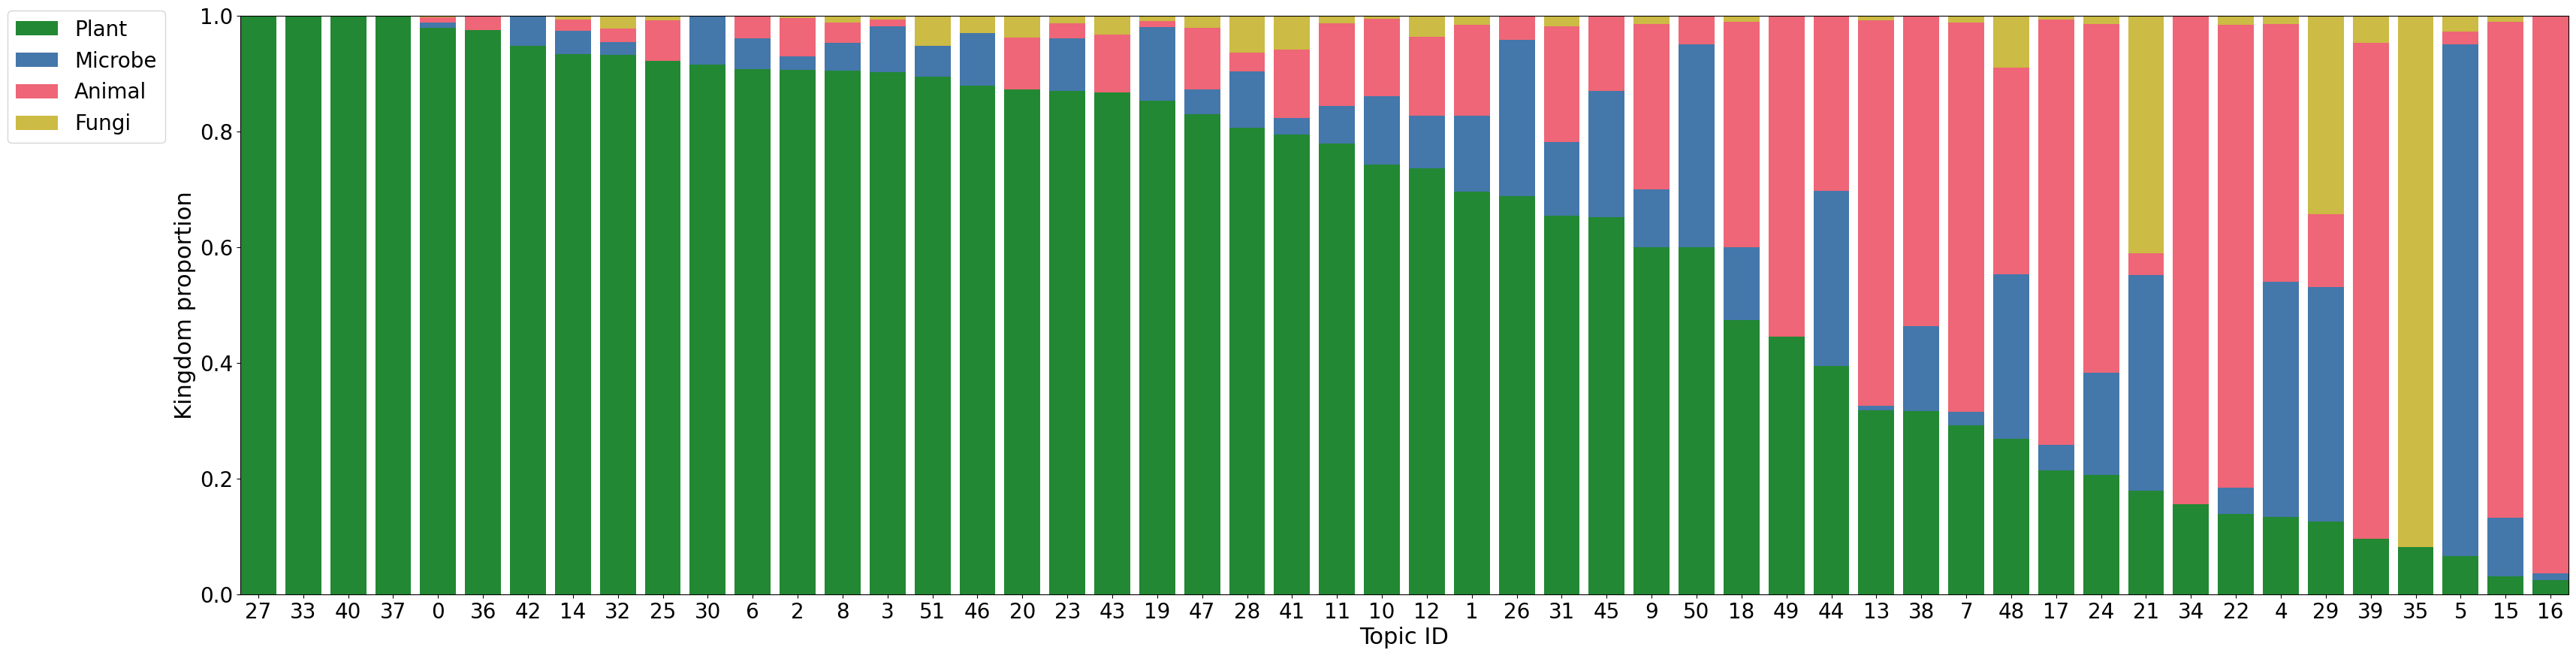

In [37]:
colors = {'Plant': '#228833', 'Animal':'#EE6677', 'Microbe': '#4477AA', 'Fungi':'#CCBB44'}
fig, ax = plt.subplots(figsize=(40,10))
bottom = np.zeros(bars_df.shape[1])

for system in bars_df.index:
    p = ax.bar(bars_df.columns.astype(str), bars_df.loc[system], color=colors[system], label=system, bottom=bottom)
    bottom += bars_df.loc[system]

# xloc_to_xlab = {txt.get_unitless_position()[0]: txt.get_text() for txt in plt.gca().get_xticklabels()}
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy()
#     to_label = x + 0.5*width
#     topic = xloc_to_xlab[to_label]
#     label = topic_counts[int(topic)]
#     ax.text(x+width/2, 
#             1.1, 
#             '{}'.format(label), 
#             horizontalalignment='center', 
#             verticalalignment='center',
#            fontsize=20)
plt.margins(x=0, tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Topic ID', fontsize=22)
plt.ylabel('Kingdom proportion', fontsize=22)
plt.legend(fontsize=20, loc=(-0.1, 0.78))

plt.savefig('../data/citation_network/figures/vertical_topic_admixture.png', format='png', bbox_inches='tight', dpi=600)

What are the topic clusters that are plant only versus those that have better distribution? Let's try making this figure horixzontally with the topic representations as the x labels.

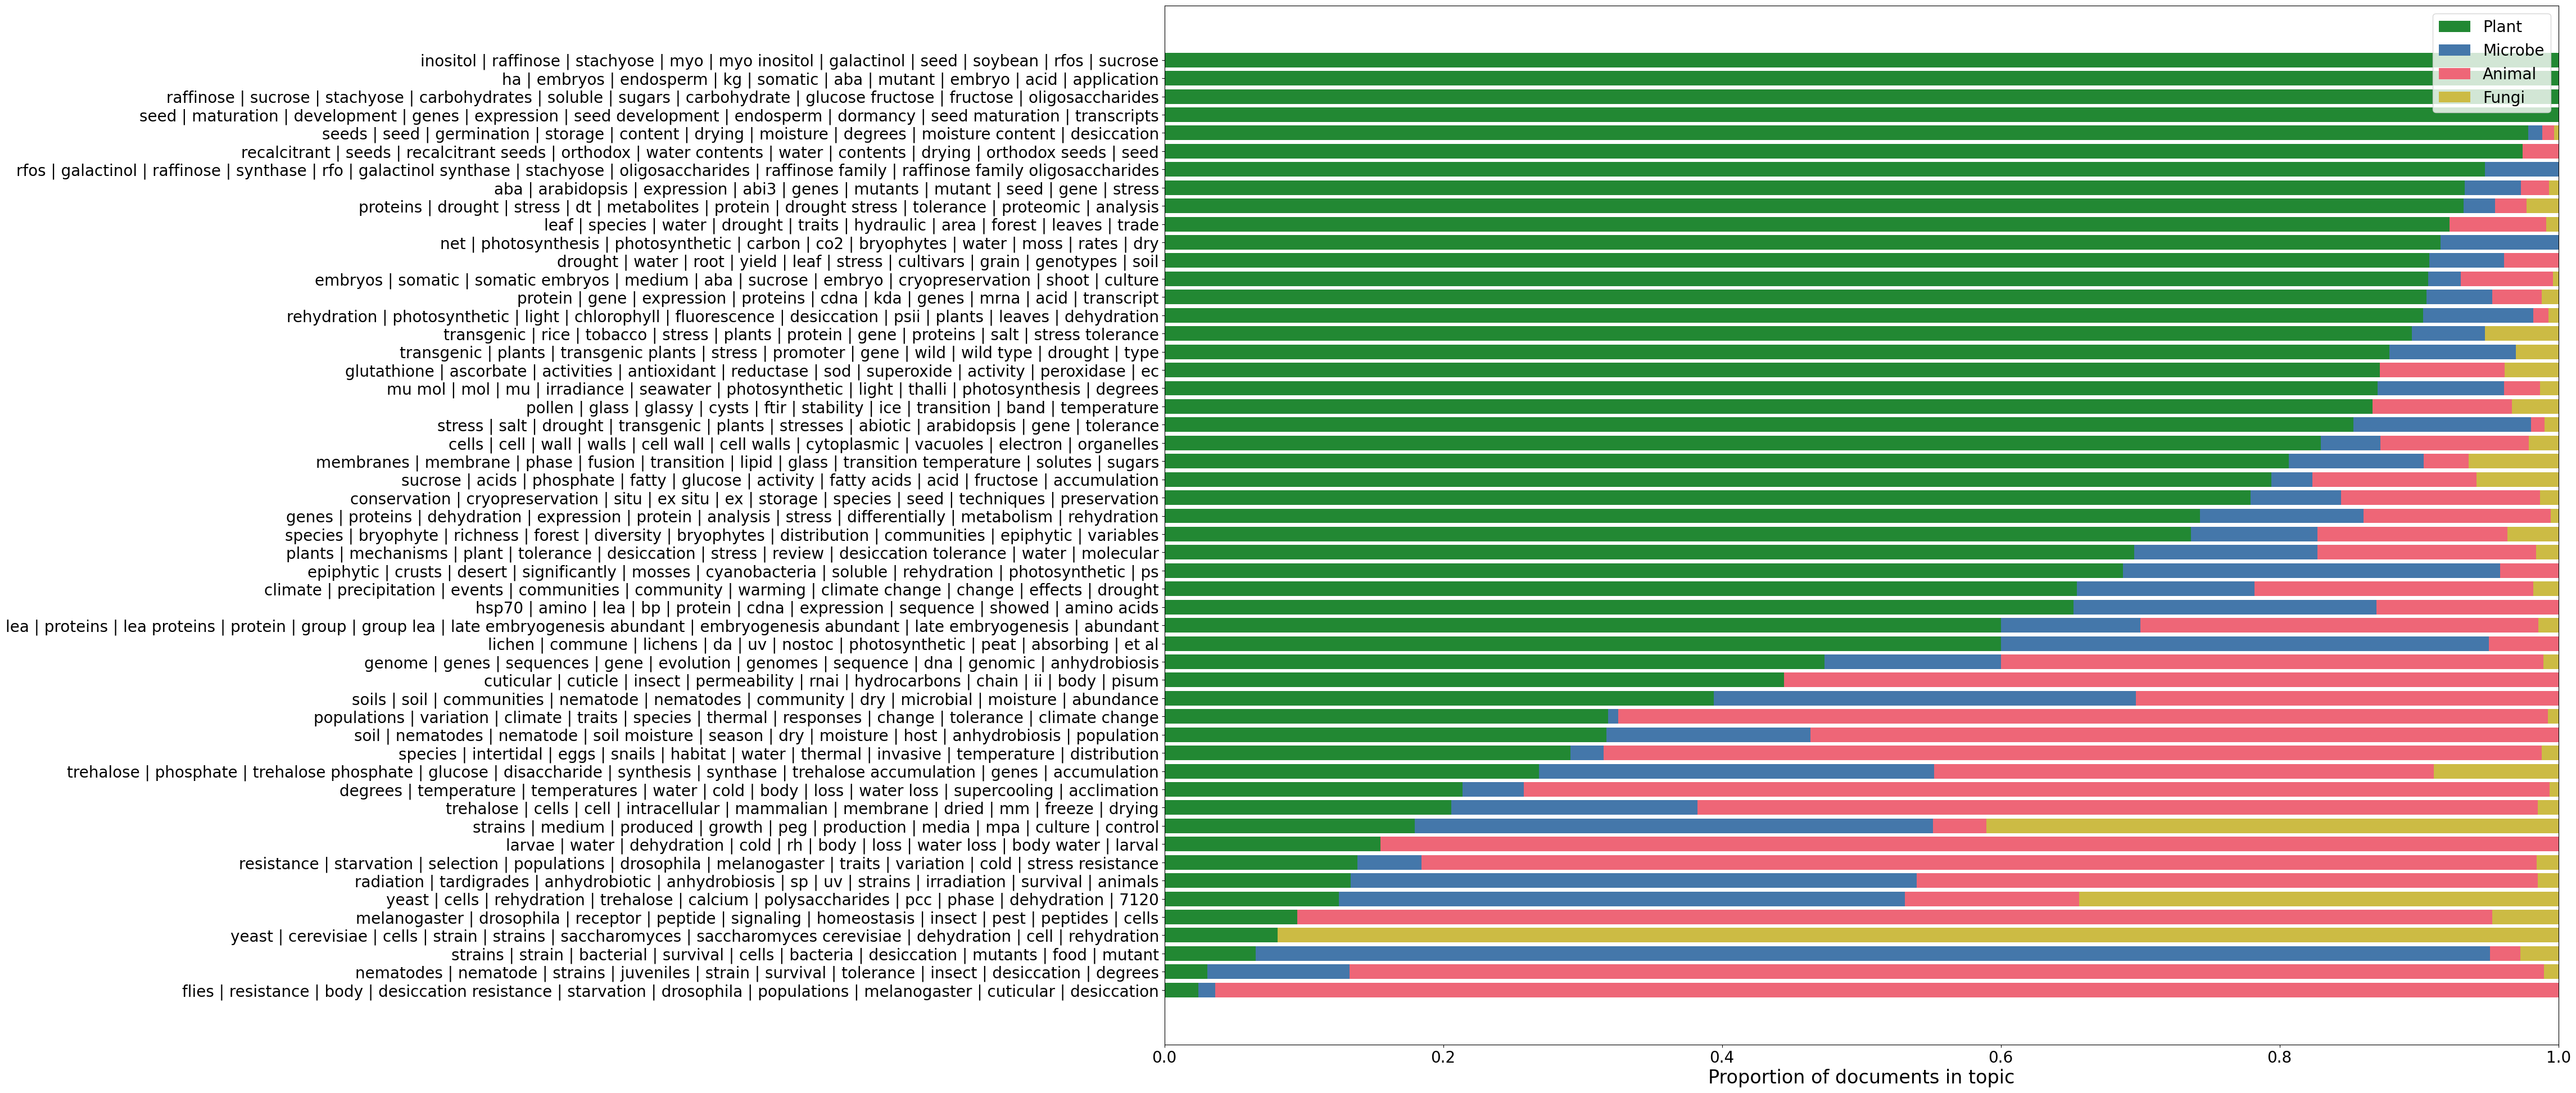

In [28]:
fig, ax = plt.subplots(figsize=(32,24))
ax.invert_yaxis()
bottom = np.zeros(bars_df.shape[1])

for system in bars_df.index:
    labs = [topic_reps[k] for k in bars_df.columns]
    p = ax.barh(labs, bars_df.loc[system], color=colors[system], label=system, left=bottom)
    bottom += bars_df.loc[system]
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Proportion of documents in topic', fontsize=24)
plt.legend(fontsize=20)
plt.savefig('../data/citation_network/figures/horizontal_topic_admixture.png', format='png', bbox_inches='tight', dpi=600)

In [30]:
# Get embeddings
embeddings = sentence_model.encode(topic_system_map['Document'], show_progress_bar=True)
umap_mapper = umap_model.fit(embeddings)

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

In [38]:
## TODO debug, broke with new UMAP params
# labels = topic_system_map['study_system']
# umap.plot.points(umap_mapper, labels=labels)

We also want to try coloring this plot by topic:

In [ ]:
labels = topic_system_map['Topic']
umap.plot.points(umap_mapper, labels=labels, show_legend=False)

## Dynamic topic modeling
Let's take a look at the representation of topics over time via [dynamic topic modeling](https://maartengr.github.io/BERTopic/getting_started/topicsovertime/topicsovertime.html#visualization). All we need to turn our single topic model into a dynamic topic model is to include the years of the documents. The important thing to note about this analysis is that the topic model is still fit glopbally, so the topic clusters are constant; the purpose of dynamic topic modeling is to get a view of how people *referred* to those topics over time, rather than looking at what topics existed or didn't exist, per-se. However, by looking at the frequency of documents belonging to each topic cluster across time, we can get a sense of the popularity of that topic over time.

In [ ]:
## Run to get a topic model without outlier reduction
# topic_model = BERTopic(embedding_model=sentence_model)
# topics, probs = topic_model.fit_transform(docs)
# vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [32]:
topics_over_time = topic_model.topics_over_time(docs, abstracts['year'], global_tuning=False, nr_bins=50)

In [33]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4])

In [49]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[40,37,35,5,16])

In [50]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[44,48,21,29])

## Hierarchical topic modeling
Another way we can look at the trends in these documents is by [hierarchical topic modeling](https://maartengr.github.io/BERTopic/getting_started/hierarchicaltopics/hierarchicaltopics.html). This groups topics according to whether there is some super-topic that could consume multiple sub-topics. Let's take a look:

In [34]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 51/51 [00:00<00:00, 166.19it/s]


In [35]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

## Topic modeling for each discipline
In the above figures, it looks like in certain instances, topics separate on kingdoms simply because of names of kingdom organisms, like "bacterial" or "nematode". We want to look at the topics independently of the kingdom they come from, and there are two ways to go about this. The first would be to build a topic model on each kingdom alone, which we'll do here. The Fungi group has too few documents, so we'll put it aside for now.

In [ ]:
# kingdom_models = {}
# for king in ['Plant', 'Animal', 'Microbe']:
#     # Get the subset of docs belonging to the kingdom
#     abstract_sub = abstracts[abstracts['study_system'] == king]
#     docs = abstract_sub.abstract.values.tolist()
#     print(f'There are {len(docs)} documents for kingdom {king}')
    
#     # Initialize input models
#     sentence_model = SentenceTransformer('allenai/scibert_scivocab_cased')
#     umap_model = UMAP(random_state=42)
#     min_cluster_size = min(round(0.01*len(docs)), 50)
#     print(f'Estimated minimum cluster size for this number of documents is {min_cluster_size}')
#     hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    
#     # Perform topic modeling
#     topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
#     topics, probs = topic_model.fit_transform(docs)
#     vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)
#     topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
#     kingdom_models[king] = topic_model